## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

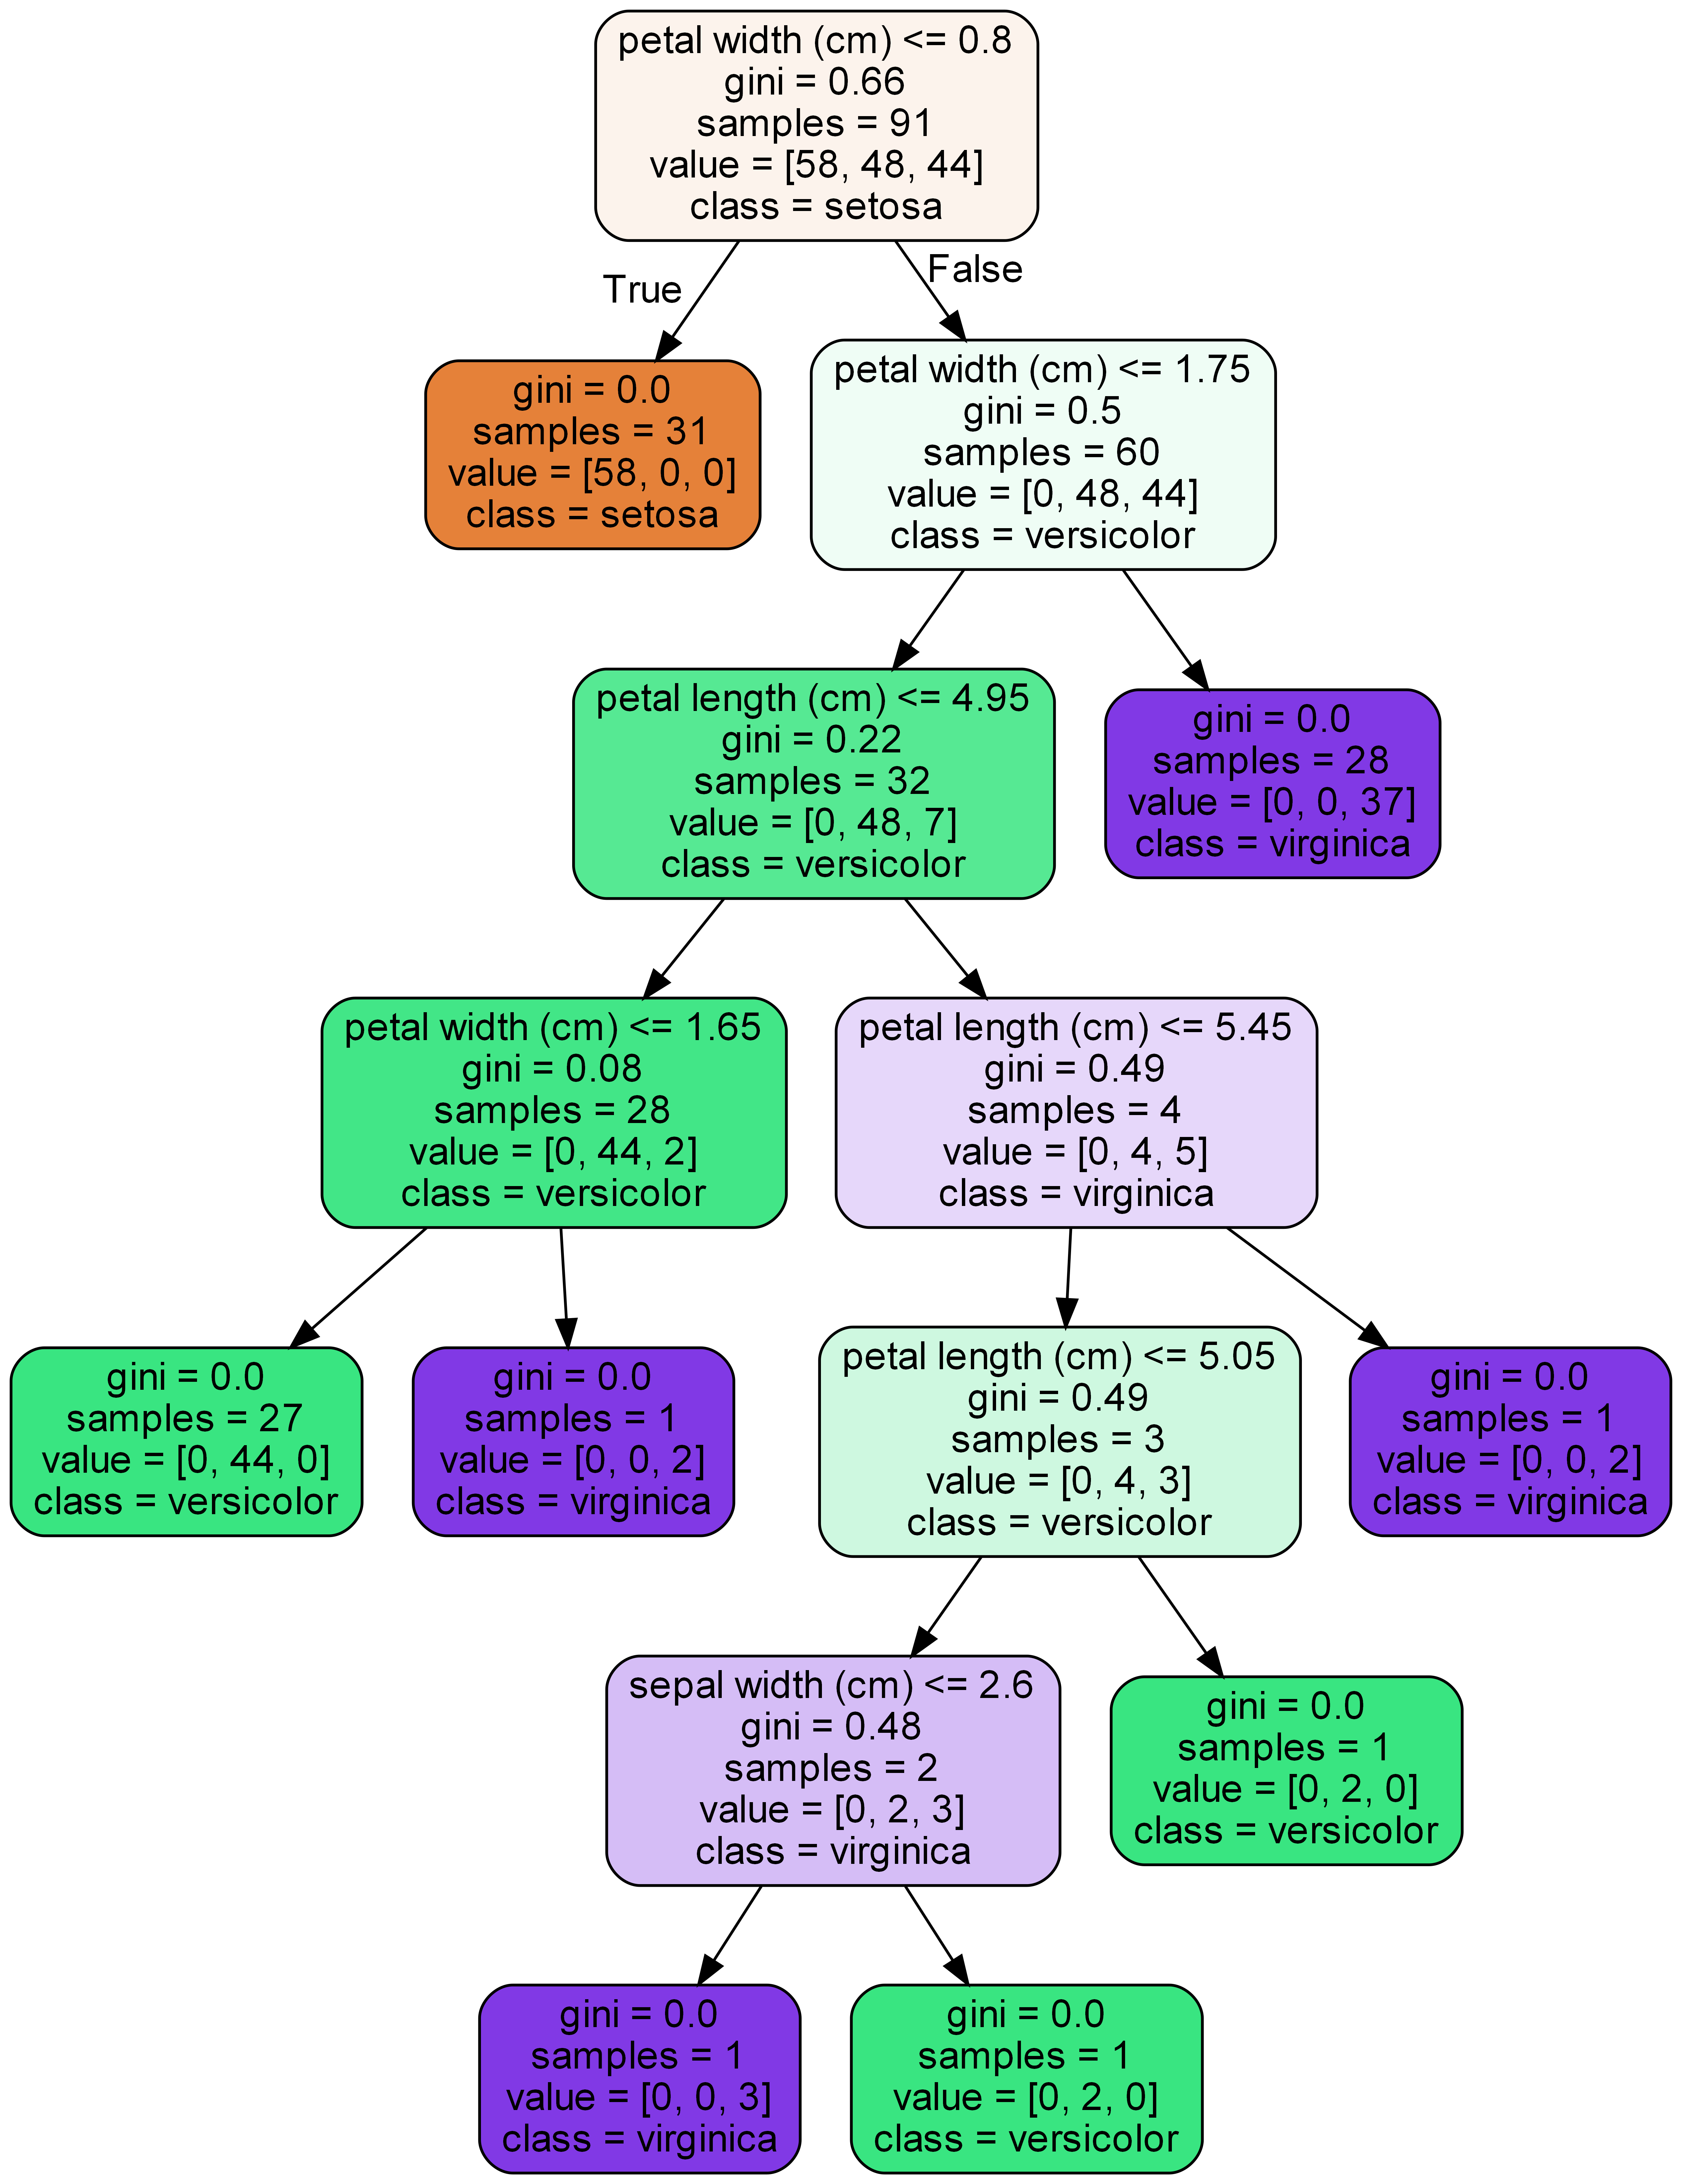

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [169]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [170]:
SKcases = r'C:\Users\yuvem\Downloads\PatientInfo.csv'
df = pd.read_csv(SKcases)
df.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [171]:
df.shape

(5165, 14)

In [172]:
df.columns

Index(['patient_id', 'sex', 'age', 'country', 'province', 'city',
       'infection_case', 'infected_by', 'contact_number', 'symptom_onset_date',
       'confirmed_date', 'released_date', 'deceased_date', 'state'],
      dtype='object')

In [173]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,deceased_date,5099
1,symptom_onset_date,4475
2,contact_number,4374
3,infected_by,3819
4,released_date,3578
5,age,1380
6,sex,1122
7,infection_case,919
8,city,94
9,confirmed_date,3


In [174]:
mapping_dict = {True: 1, np.nan: 0}
df.contact_number.replace(mapping_dict, inplace = True)

In [175]:
df.isna().sum()

patient_id               0
sex                   1122
age                   1380
country                  0
province                 0
city                    94
infection_case         919
infected_by           3819
contact_number           0
symptom_onset_date    4475
confirmed_date           3
released_date         3578
deceased_date         5099
state                    0
dtype: int64

In [176]:
mapping_dict = {True: 1, np.nan: 0}
df.infected_by.replace(mapping_dict, inplace = True)

In [177]:
df.isna().sum()

patient_id               0
sex                   1122
age                   1380
country                  0
province                 0
city                    94
infection_case         919
infected_by              0
contact_number           0
symptom_onset_date    4475
confirmed_date           3
released_date         3578
deceased_date         5099
state                    0
dtype: int64

In [178]:
mapping_dict = {True: 1, np.nan: 0}
df.infection_case.replace(mapping_dict, inplace = True)

In [179]:
df.isna().sum()

patient_id               0
sex                   1122
age                   1380
country                  0
province                 0
city                    94
infection_case           0
infected_by              0
contact_number           0
symptom_onset_date    4475
confirmed_date           3
released_date         3578
deceased_date         5099
state                    0
dtype: int64

In [180]:
mapping_dict = {True: 1, np.nan: 0}
df.age.replace(mapping_dict, inplace = True)

In [181]:
df.isna().sum()

patient_id               0
sex                   1122
age                      0
country                  0
province                 0
city                    94
infection_case           0
infected_by              0
contact_number           0
symptom_onset_date    4475
confirmed_date           3
released_date         3578
deceased_date         5099
state                    0
dtype: int64

In [182]:
no_s = df.age.str.replace('s','', regex=True)
df.age = pd.to_numeric(no_s)

In [183]:
df.shape

(5165, 14)

In [184]:
df.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50.0,Korea,Seoul,Gangseo-gu,overseas inflow,0,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30.0,Korea,Seoul,Jungnang-gu,overseas inflow,0,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50.0,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20.0,Korea,Seoul,Mapo-gu,overseas inflow,0,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20.0,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [193]:
#counts of response variable values
df.state.value_counts()

released    2929
isolated    2158
deceased      78
Name: state, dtype: int64

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165 entries, 0 to 5164
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          5165 non-null   int64  
 1   sex                 4043 non-null   object 
 2   age                 3785 non-null   float64
 3   country             5165 non-null   object 
 4   province            5165 non-null   object 
 5   city                5071 non-null   object 
 6   infection_case      5165 non-null   object 
 7   infected_by         5164 non-null   float64
 8   contact_number      5165 non-null   object 
 9   symptom_onset_date  690 non-null    object 
 10  confirmed_date      5162 non-null   object 
 11  released_date       1587 non-null   object 
 12  deceased_date       66 non-null     object 
 13  state               5165 non-null   object 
dtypes: float64(2), int64(1), object(11)
memory usage: 565.0+ KB


In [195]:
df.infected_by.unique()

array([0.00000000e+00, 2.00200000e+09, 1.00000000e+09, 1.00000000e+09,
       1.00000002e+09, 1.00000001e+09, 1.00000002e+09, 1.00000002e+09,
       1.00000002e+09, 1.00000002e+09, 1.00000003e+09, 1.00000003e+09,
       1.50000000e+09, 1.00000003e+09, 1.00000004e+09, 1.00000005e+09,
       1.00000006e+09, 2.01700000e+09, 1.00000005e+09, 1.00000007e+09,
       1.00000002e+09, 1.00000011e+09, 1.00000012e+09, 1.00000004e+09,
       1.00000011e+09, 1.00000012e+09, 1.00000011e+09, 1.00000010e+09,
       1.00000013e+09, 1.00000014e+09, 1.00000012e+09, 1.00000013e+09,
       1.00000012e+09, 1.00000016e+09, 1.00000021e+09, 1.00000021e+09,
       1.00000023e+09, 1.00000024e+09, 1.00000025e+09, 1.00000025e+09,
       1.00000028e+09, 1.00000027e+09, 1.00000022e+09, 1.00000026e+09,
       1.00000030e+09, 1.00000030e+09, 1.00000032e+09, 1.00000021e+09,
       1.00000031e+09, 1.00000033e+09, 1.00000029e+09, 1.00000014e+09,
       1.00000035e+09, 1.00000023e+09, 1.00000036e+09, 1.00000039e+09,
      

In [196]:
df.contact_number.unique()

array(['75', '31', '17', '9', '2', '43', '0', '68', '6', '23', '117',
       '27', '8', 0, '4', '3', '1', '1000000796', '13', '12', '1091',
       '131', '16', '14', '485', '19', '296', '15', '34', '37', '22', '7',
       '10', '28', '21', '5', '25', '18', '159', '11', '30', '41', '71',
       '38', '24', '185', '69', '39', '1160', '450', '65', '156', '47',
       '86', '74', '46', '64', '66', '40', '20', '42', '107', '29', '26',
       '45', '-', '95', '422', '290', '32', '53', '70', '35', '51', '130',
       '106', '174', '78', '33', '89', '61', '113', '36', '6100000098',
       '6100000099', '87', '84', '140', '72'], dtype=object)

In [197]:
df['contact_number'] = df['contact_number'].fillna(0)
df['infected_by'] = df['infected_by'].fillna(0)

In [201]:
df = df[df['contact_number'] != '-']

In [202]:
df['contact_number'].unique()

array(['75', '31', '17', '9', '2', '43', '0', '68', '6', '23', '117',
       '27', '8', 0, '4', '3', '1', '1000000796', '13', '12', '1091',
       '131', '16', '14', '485', '19', '296', '15', '34', '37', '22', '7',
       '10', '28', '21', '5', '25', '18', '159', '11', '30', '41', '71',
       '38', '24', '185', '69', '39', '1160', '450', '65', '156', '47',
       '86', '74', '46', '64', '66', '40', '20', '42', '107', '29', '26',
       '45', '95', '422', '290', '32', '53', '70', '35', '51', '130',
       '106', '174', '78', '33', '89', '61', '113', '36', '6100000098',
       '6100000099', '87', '84', '140', '72'], dtype=object)

In [203]:
df.infected_by.unique()

array([0.00000000e+00, 2.00200000e+09, 1.00000000e+09, 1.00000000e+09,
       1.00000002e+09, 1.00000001e+09, 1.00000002e+09, 1.00000002e+09,
       1.00000002e+09, 1.00000002e+09, 1.00000003e+09, 1.00000003e+09,
       1.50000000e+09, 1.00000003e+09, 1.00000004e+09, 1.00000005e+09,
       1.00000006e+09, 2.01700000e+09, 1.00000005e+09, 1.00000007e+09,
       1.00000002e+09, 1.00000011e+09, 1.00000012e+09, 1.00000004e+09,
       1.00000011e+09, 1.00000012e+09, 1.00000011e+09, 1.00000010e+09,
       1.00000013e+09, 1.00000014e+09, 1.00000012e+09, 1.00000013e+09,
       1.00000012e+09, 1.00000016e+09, 1.00000021e+09, 1.00000021e+09,
       1.00000023e+09, 1.00000024e+09, 1.00000025e+09, 1.00000025e+09,
       1.00000028e+09, 1.00000027e+09, 1.00000022e+09, 1.00000026e+09,
       1.00000030e+09, 1.00000030e+09, 1.00000032e+09, 1.00000021e+09,
       1.00000031e+09, 1.00000033e+09, 1.00000029e+09, 1.00000014e+09,
       1.00000035e+09, 1.00000023e+09, 1.00000036e+09, 1.00000039e+09,
      

In [204]:
df.infected_by = pd.to_numeric(df.infected_by,errors='coerce')
df.contact_number = pd.to_numeric(df.contact_number)

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5161 entries, 0 to 5164
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          5161 non-null   int64  
 1   sex                 4039 non-null   object 
 2   age                 3781 non-null   float64
 3   country             5161 non-null   object 
 4   province            5161 non-null   object 
 5   city                5067 non-null   object 
 6   infection_case      5161 non-null   object 
 7   infected_by         5161 non-null   float64
 8   contact_number      5161 non-null   int64  
 9   symptom_onset_date  688 non-null    object 
 10  confirmed_date      5158 non-null   object 
 11  released_date       1583 non-null   object 
 12  deceased_date       66 non-null     object 
 13  state               5161 non-null   object 
dtypes: float64(2), int64(2), object(10)
memory usage: 604.8+ KB


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [206]:
np.sum(df.isna())

patient_id               0
sex                   1122
age                   1380
country                  0
province                 0
city                    94
infection_case           0
infected_by              0
contact_number           0
symptom_onset_date    4473
confirmed_date           3
released_date         3578
deceased_date         5095
state                    0
dtype: int64

In [207]:
#Fill null values in the following columns with their mean: infected_by'and 'contact_number'
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = df[['infected_by', 'contact_number']]
imputer.fit(X)

SimpleImputer()

In [208]:
df[['infected_by', 'contact_number']] = imputer.transform(X)

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5161 entries, 0 to 5164
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          5161 non-null   int64  
 1   sex                 4039 non-null   object 
 2   age                 3781 non-null   float64
 3   country             5161 non-null   object 
 4   province            5161 non-null   object 
 5   city                5067 non-null   object 
 6   infection_case      5161 non-null   object 
 7   infected_by         5161 non-null   float64
 8   contact_number      5161 non-null   float64
 9   symptom_onset_date  688 non-null    object 
 10  confirmed_date      5158 non-null   object 
 11  released_date       1583 non-null   object 
 12  deceased_date       66 non-null     object 
 13  state               5161 non-null   object 
dtypes: float64(3), int64(1), object(10)
memory usage: 604.8+ KB


In [210]:
df.shape

(5161, 14)

In [211]:
df.age.unique()

array([ 50.,  30.,  20.,  60.,  80.,  70.,  40.,  10.,  90.,   0.,  nan,
       100.])

In [212]:
df['age'] = df['age'].fillna(0)

In [213]:
df.age.unique()

array([ 50.,  30.,  20.,  60.,  80.,  70.,  40.,  10.,  90.,   0., 100.])

In [214]:
df.shape

(5161, 14)

In [215]:
df.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50.0,Korea,Seoul,Gangseo-gu,overseas inflow,0.000000e+00,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30.0,Korea,Seoul,Jungnang-gu,overseas inflow,0.000000e+00,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50.0,Korea,Seoul,Jongno-gu,contact with patient,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20.0,Korea,Seoul,Mapo-gu,overseas inflow,0.000000e+00,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20.0,Korea,Seoul,Seongbuk-gu,contact with patient,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


Remove date columns from the data.


In [216]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

In [217]:
df.columns

Index(['patient_id', 'sex', 'age', 'country', 'province', 'city',
       'infection_case', 'infected_by', 'contact_number', 'state'],
      dtype='object')

Review the count of unique values by column.

In [218]:
print(df.nunique())

patient_id        5160
sex                  2
age                 11
country             16
province            17
city               163
infection_case      52
infected_by        605
contact_number      87
state                3
dtype: int64


Review the percent of unique values by column.

In [219]:
print(df.nunique()/df.shape[0])

patient_id        0.999806
sex               0.000388
age               0.002131
country           0.003100
province          0.003294
city              0.031583
infection_case    0.010076
infected_by       0.117225
contact_number    0.016857
state             0.000581
dtype: float64


Review the range of values per column.

In [220]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,5161.0,2.864536e+09,2.074761e+09,1.000000e+09,1.000001e+09,2.000000e+09,6.001000e+09,7.000000e+09
age,5161.0,2.957760e+01,2.486584e+01,0.000000e+00,0.000000e+00,3.000000e+01,5.000000e+01,1.000000e+02
infected_by,5161.0,5.950551e+08,1.269921e+09,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+09,7.000000e+09
contact_number,5161.0,2.557647e+06,1.208707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.100000e+09


### Check for duplicated rows

In [221]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,state


Print the categorical columns and their associated levels.

In [222]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,country,16
2,province,17
3,city,163
4,infection_case,52
5,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

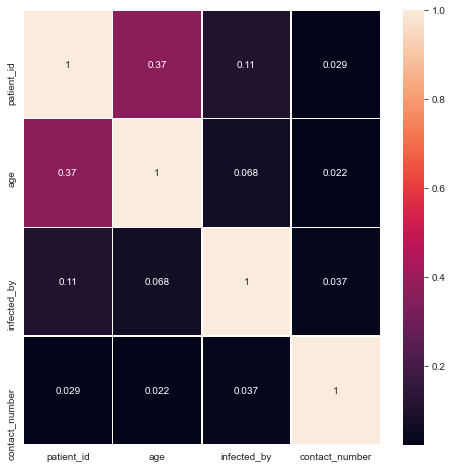

In [233]:
# Make heatmap of data
_= plt.figure(figsize=(8,8))
heatmap = sns.heatmap(df.corr(), annot=True, linewidth=0.6)
plt.show()

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

In [234]:
# Check for numeric columns and outliers
cols = df.select_dtypes([np.number]).columns
print(cols)

Index(['patient_id', 'age', 'infected_by', 'contact_number'], dtype='object')


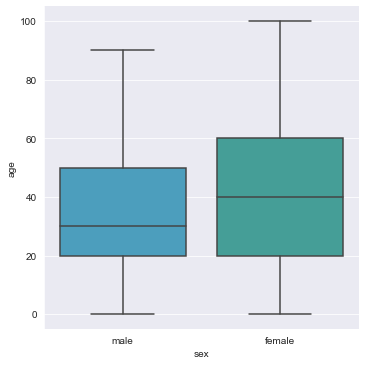

In [235]:
sns.set_style("darkgrid")
custom_palette = ["#39A7D0","#36ADA4"]
sns.set_palette(custom_palette)

sns.catplot(x="sex", y="age", data=df, kind="box")
plt.show()

In [237]:
y = df["state"]

In [238]:
y.head()

0    released
1    released
2    released
3    released
4    released
Name: state, dtype: object

In [239]:
X = df.drop(columns = ["state"])

In [240]:
X.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number
0,1000000001,male,50.0,Korea,Seoul,Gangseo-gu,overseas inflow,0.000000e+00,75.0
1,1000000002,male,30.0,Korea,Seoul,Jungnang-gu,overseas inflow,0.000000e+00,31.0
2,1000000003,male,50.0,Korea,Seoul,Jongno-gu,contact with patient,2.002000e+09,17.0
3,1000000004,male,20.0,Korea,Seoul,Mapo-gu,overseas inflow,0.000000e+00,9.0
4,1000000005,female,20.0,Korea,Seoul,Seongbuk-gu,contact with patient,1.000000e+09,2.0


In [241]:
X.columns

Index(['patient_id', 'sex', 'age', 'country', 'province', 'city',
       'infection_case', 'infected_by', 'contact_number'],
      dtype='object')

**<font color='teal'> Create dummy features for object type features. </font>**

In [242]:
X = pd.get_dummies(X)

In [243]:
X.columns

Index(['patient_id', 'age', 'infected_by', 'contact_number', 'sex_female',
       'sex_male', 'country_Bangladesh', 'country_Canada', 'country_China',
       'country_Foreign',
       ...
       'infection_case_Wangsung Church',
       'infection_case_Yangcheon Table Tennis Club',
       'infection_case_Yeonana News Class',
       'infection_case_Yeongdeungpo Learning Institute',
       'infection_case_Yongin Brothers', 'infection_case_contact with patient',
       'infection_case_etc', 'infection_case_gym facility in Cheonan',
       'infection_case_gym facility in Sejong',
       'infection_case_overseas inflow'],
      dtype='object', length=254)

In [244]:
X.head()

,patient_id,age,infected_by,contact_number,sex_female,sex_male,country_Bangladesh,country_Canada,country_China,country_Foreign,...,infection_case_Wangsung Church,infection_case_Yangcheon Table Tennis Club,infection_case_Yeonana News Class,infection_case_Yeongdeungpo Learning Institute,infection_case_Yongin Brothers,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow
0,1000000001,50.0,0.000000e+00,75.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1000000002,30.0,0.000000e+00,31.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1000000003,50.0,2.002000e+09,17.0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1000000004,20.0,0.000000e+00,9.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1000000005,20.0,1.000000e+09,2.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### Split the data into test and train subsamples

In [245]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [246]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [247]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [248]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.883
Random Forest: f1-score=0.879


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [249]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[  6   2  14]
 [  1 371  51]
 [  0  53 535]]
Normalized confusion matrix
[[0.27 0.09 0.64]
 [0.   0.88 0.12]
 [0.   0.09 0.91]]


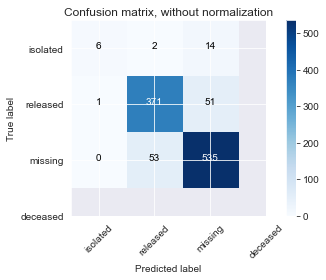

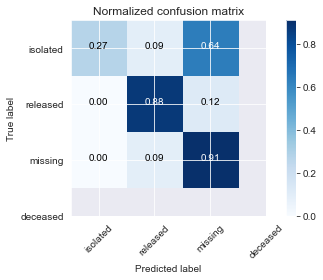

In [250]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


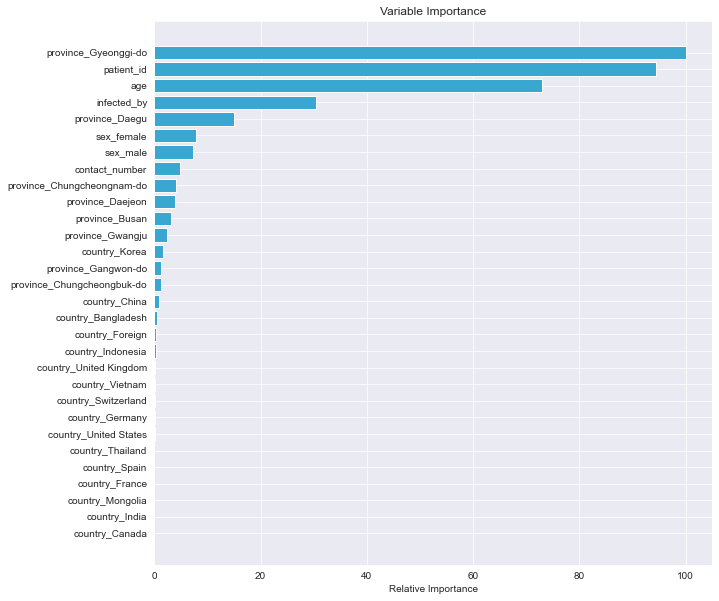

In [251]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.